In [1]:
import numpy as np
import pandas as pd
import scienceplots
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets
from itertools import combinations, product
from huggingface_hub import login as hf_login
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [20]:
ds = load_dataset("beanham/spatial_union_dataset")
train=ds['train']
test=ds['test']
positive=train.filter(lambda x: x['label']==1)
negative=train.filter(lambda x: x['label']==0)
train_pd=train.to_pandas()
test=test.to_pandas()

## Training Distribution

## Angle Degrees

In [3]:
name='min_angle'
data=train
print('Min:', np.min(data[name]))
print('Median:', np.median(data[name]))
print('Mean:', np.mean(data[name]))
print('Max:', np.max(data[name]))
print('STD:', np.std(data[name]))

Min: 0.0
Median: 0.2534106510876768
Mean: 8.173721970442841
Max: 89.99142574384204
STD: 20.47682558738981


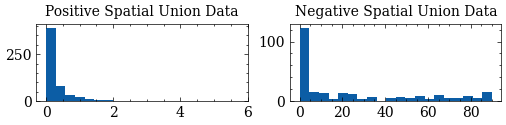

In [4]:
title_size=10
plt.style.use('science')
plt.rc('text', usetex=False)
plt.figure(figsize=(6,1))
plt.subplot(1, 2, 1)
plt.hist(positive[name], bins=20)
plt.title('Positive Spatial Union Data', fontsize=title_size)
plt.xlabel("")
plt.subplot(1, 2, 2)
plt.hist(negative[name], bins=20)
plt.title('Negative Spatial Union Data', fontsize=title_size)
plt.xlabel("")
#plt.savefig(f"../../misc/union_task_min_angle_distribution.png", bbox_inches='tight',pad_inches=0, dpi=600)
pass

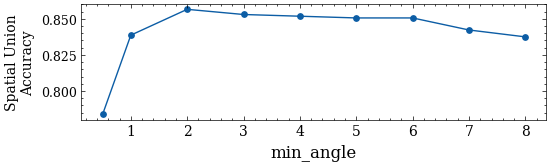

In [5]:
metrics=[0.5,1,2,3,4,5,6,7,8]
train_gt=np.array(train['label'])
accuracy=[]
for m in metrics:
    pred=np.array(train[name])<=m
    accuracy.append(accuracy_score(train_gt, pred))
plt.figure(figsize=(6,1.5))
plt.plot(metrics,accuracy,label='accuracy')
plt.scatter(metrics, accuracy,s=15)
plt.yticks(fontsize=9)
plt.ylabel('Spatial Union\nAccuracy', fontsize=10)
plt.xlabel('min_angle', fontsize=12)
#plt.savefig(f"../../misc/union_task_min_angle_train_acc.png", bbox_inches='tight',pad_inches=0.01, dpi=600)
pass    

## Max Area

In [9]:
name='max_area'
data=train
print('Min:', np.min(data[name]))
print('Median:', np.median(data[name]))
print('Mean:', np.mean(data[name]))
print('Max:', np.max(data[name]))
print('STD:', np.std(data[name]))

Min: 0.04663239549739347
Median: 0.9554050531812308
Mean: 0.7464377419605231
Max: 0.9997474675972201
STD: 0.31809474912618424


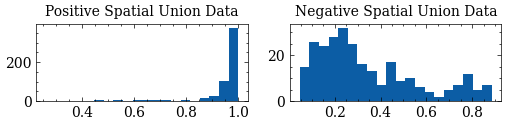

In [10]:
title_size=10
plt.style.use('science')
plt.rc('text', usetex=False)
plt.figure(figsize=(6,1))
plt.subplot(1, 2, 1)
plt.hist(positive[name], bins=20)
plt.title('Positive Spatial Union Data', fontsize=title_size)
plt.xlabel("")
plt.subplot(1, 2, 2)
plt.hist(negative[name], bins=20)
plt.title('Negative Spatial Union Data', fontsize=title_size)
plt.xlabel("")
#plt.savefig(f"../../misc/union_task_max_area_distribution.png", bbox_inches='tight',pad_inches=0, dpi=600)
pass

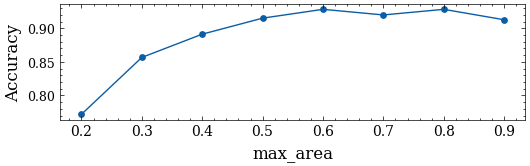

In [11]:
metrics=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
train_gt=np.array(train['label'])
accuracy=[]
for m in metrics:
    pred=np.array(train[name])>=m
    accuracy.append(accuracy_score(train_gt, pred))
plt.figure(figsize=(6,1.5))
plt.plot(metrics,accuracy,label='accuracy')
plt.scatter(metrics, accuracy,s=15)
plt.yticks(fontsize=9)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('max_area', fontsize=12)
#plt.savefig(f"../../misc/union_task_max_area_train_acc.png", bbox_inches='tight',pad_inches=0.01, dpi=600)
pass    

## Comb

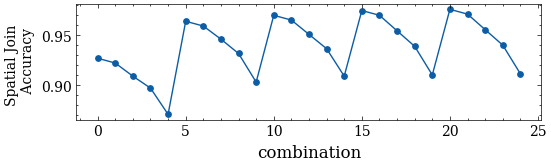

In [39]:
angles=[1,2,3,4,5]
areas=[0.5,0.6,0.7,0.8,0.9]
train_gt=np.array(train['label'])
combs=list(product(angles, areas))
accuracy=[]
for a,m in combs:
    pred=(np.array(train['min_angle'])<=a)&(np.array(train['max_area'])>=m)
    accuracy.append(accuracy_score(train_gt, pred))
plt.figure(figsize=(6,1.5))
plt.plot(range(len(combs)),accuracy,label='accuracy')
plt.scatter(range(len(combs)), accuracy,s=15)
plt.ylabel('Spatial Join \n Accuracy', fontsize=10)
plt.xlabel('combination', fontsize=12)
#plt.savefig(f"../../misc/join_task_min_distance_train_acc.png", bbox_inches='tight',pad_inches=0.01, dpi=600)
pass

# Test Inference

In [17]:
def metric_calculation(pred, gt):    
    acc=accuracy_score(gt, pred)
    f1=f1_score(gt, pred, average='macro')
    confusion=confusion_matrix(gt, pred)
    fpr=confusion[0,1]/len(gt) ## predict to be 1; actual 0
    fnr=confusion[1,0]/len(gt) ## predict to be 0; actual 1
    return acc, f1, fpr, fnr

In [28]:
## angle
gt=np.array(test['label'])
for i in [1,2,3,4,5]:
    pred=np.array(test['min_angle'])<=i
    metrics=metric_calculation(pred, gt)
    print(i, round(metrics[0],3))

1 0.857
2 0.867
3 0.857
4 0.842
5 0.842


In [29]:
## area
for i in [0.5,0.6,0.7,0.8,0.9]:
    pred=np.array(test['max_area'])>=i
    metrics=metric_calculation(pred, gt)
    print(i, round(metrics[0],3))

0.5 0.882
0.6 0.902
0.7 0.91
0.8 0.927
0.9 0.917


In [31]:
## combination (angle, area)
angles=[1,2,3,4,5]
max_area=[0.5,0.6,0.7,0.8,0.9]
test_gt=np.array(test['label'])
combs=list(product(angles, max_area))
accuracy=[]
for a,m in combs:
    pred=(np.array(test['max_area'])>=m)&(np.array(test['min_angle'])<=a)
    accuracy.append([a,m,accuracy_score(test_gt, pred)])
accuracy_comb2=pd.DataFrame(accuracy,columns=['angle','area','acc'])
accuracy_comb2.head()

,angle,area,acc
0,1,0.5,0.922306
1,1,0.6,0.909774
2,1,0.7,0.904762
3,1,0.8,0.902256
4,1,0.9,0.869674


In [37]:
accuracy_comb2[accuracy_comb2['angle']==5].T

,20,21,22,23,24
angle,5.000000,5.000000,5.000000,5.000000,5.000000
area,0.500000,0.600000,0.700000,0.800000,0.900000
acc,0.954887,0.949875,0.949875,0.947368,0.914787
